This notebook can be used to adjust the ground truth coordinates to accommodate cropping and rotation. You can consider it as warping the drill videos in the same way we warped the detection video. Skip this step if the coordinates of your ground truth videos and the detection videos are already comparable, aligning in the same direction and containing solely the area of interest.

### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### TODO

In [2]:
# fill in the path on your machine
formation_name = "Queen-1"
formation_video_folder = "/data/huanga/Synchrony/formation_videos/" # where the video of the formation is stored
formation_frames_folder = "/data/huanga/Synchrony/formation_frames/" # where the frames of the formation are stored
formation_folder = "/data/huanga/Synchrony/formation/" # where the ground truth formation is stored (assumed in numpy format)

"""
NOTE: the formation is assumed to be a numpy array that contains the coordinates of the members of the formation at each frame. 
If your formation is not stored in this way, please convert it to the following format:

all_coords = [

    # coordinates for the first frame
    {   
        # coordinates for the first member
        1 : (x, y),
        
        # coordinates for the second member
        2 : (x, y),
        
        ...
    }
    
    # coordinates for the second frame
    {   
        1 : (x, y),
        2 : (x, y),
        ...
    }
]
"""

os.makedirs(formation_frames_folder, exist_ok=True)
os.makedirs(os.path.join(formation_frames_folder, formation_name), exist_ok=True)

### Extract the first frame of the formation video

Just like how we did in frames_to_warped_frames.ipynb, we will find the warping that works for the first frame of the formation video and then apply the same warping to the rest of the frames.

In [3]:
# TODO: Here we assume that the formation video is in mp4 format. Please use free online tools to convert the video to mp4 format if it is not.
vid = cv2.VideoCapture(os.path.join(formation_video_folder, f"{formation_name}.mp4"))
index = 1
while True:
    ret, frame = vid.read()
    if not ret:
        break
    cv2.imwrite(os.path.join(formation_frames_folder, formation_name, f"frame_{index:04d}.jpg"), frame)
    break

### Find the boundaries of the area of interest

Find the proper padding so that the red lines overlap with the boundaries of the area in interest. Note that if everything is set up correctly, the red dots should also overlap with where the members are standing.

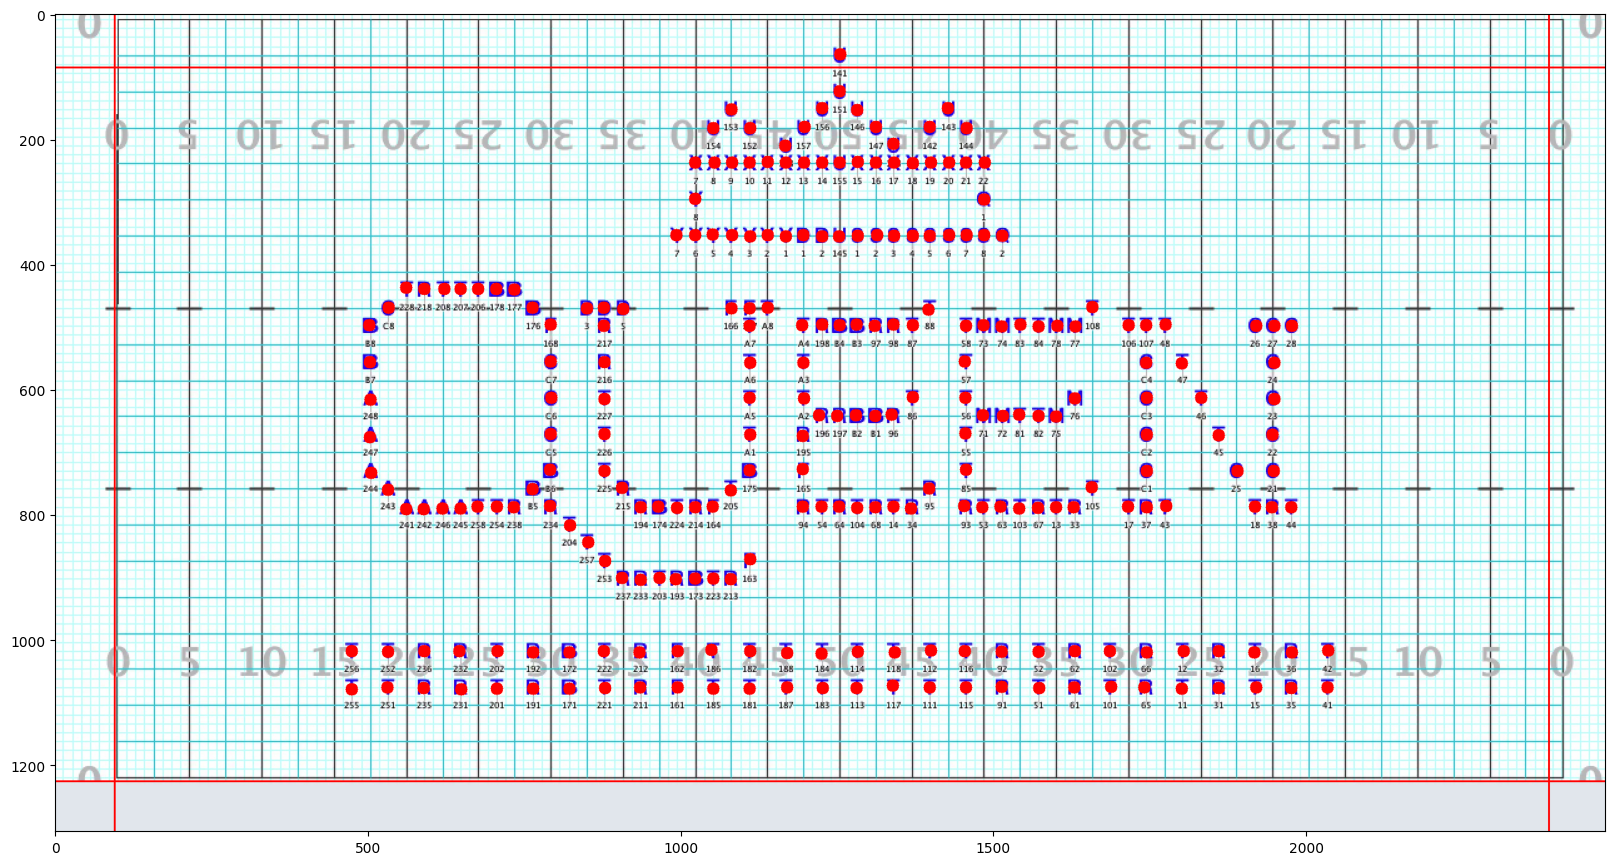

In [4]:
# TODO: adjust this manually to crop the football field
left_pad, right_pad, top_pad, bottom_pad = 95, 90, 85, 80 

# find the boundaries of the football field for later cropping
first_frame = cv2.imread(os.path.join(formation_frames_folder, formation_name, f"frame_0001.jpg"))
all_coords = np.load(os.path.join(formation_folder, f"{formation_name}.npy"), allow_pickle=True)
first_coord = all_coords[0]
max_x, max_y = first_frame.shape[1], first_frame.shape[0]
cv2.line(first_frame, (left_pad, 0), (left_pad, max_y), (0, 0, 255), 2) # left line
cv2.line(first_frame, (max_x - right_pad, 0), (max_x - right_pad, max_y), (0, 0, 255), 2) # right line
cv2.line(first_frame, (0, top_pad), (max_x, top_pad), (0, 0, 255), 2) # top line
cv2.line(first_frame, (0, max_y - bottom_pad), (max_x, max_y - bottom_pad), (0, 0, 255), 2) # bottom line

# visualize the ground truth coordinates
for member_index, coord in first_coord.items():
    cv2.circle(first_frame, (int(coord[0]), int(coord[1])), 10, (0, 0, 255), -1)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))

### Apply warping on the first frame

Make sure that the image is warped properly, and the newly drawn blue dots fully covers the red dots.

<b>IMPORTANT: </b> take note of the shape of the transformed frame as it will be used in match_ground_truth_to_detection.ipynb

Shape of the transformed frame: (1425, 2721, 3)


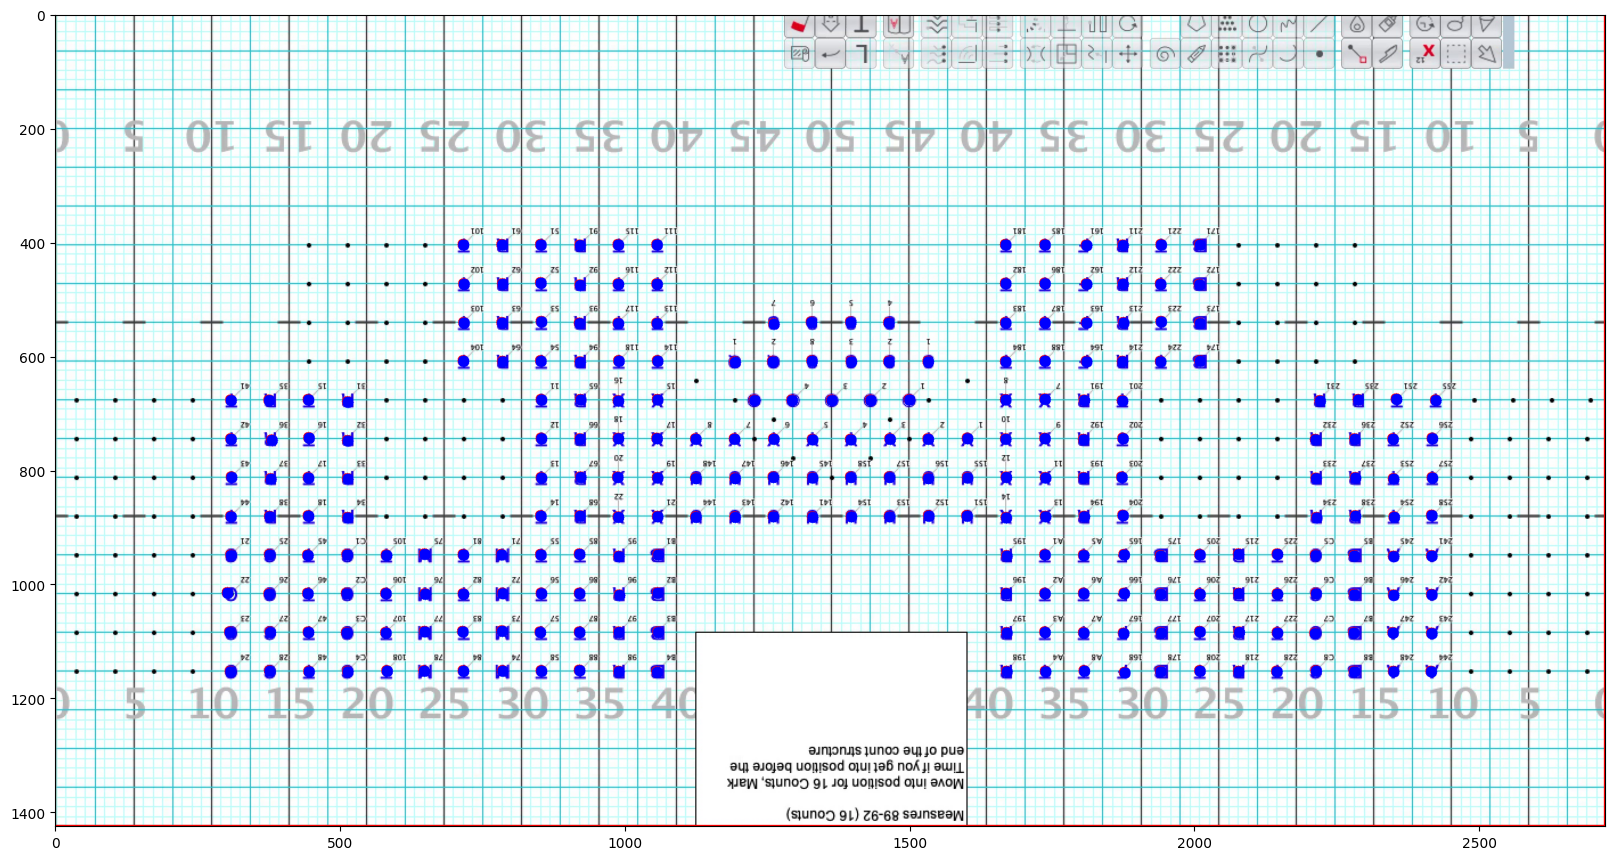

In [19]:
# rotate the frame
transformed = cv2.rotate(first_frame[top_pad : max_y - bottom_pad, left_pad : max_x - right_pad], cv2.ROTATE_180)
transformed_shape = transformed.shape
print("Shape of the transformed frame:", transformed_shape)

# make sure that after the rotation and cropping, the coordinates are still correct
for index, coord in first_coord.items():
    rotated_coord = (transformed.shape[1] - (int(coord[0]) - left_pad), transformed.shape[0] - (int(coord[1]) - top_pad))
    cv2.circle(transformed, rotated_coord, 10, (255, 0, 0), -1)
     
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))

### Apply the warping to the rest of the frames

Please double check if the area of interest stays in the same place <b>THROUGHOUT</b> the whole video.

In [28]:
# adjust the coordinates to match the cropped and rotated formation image
all_warped_coords = []
for frame_index, frame_coord in enumerate(all_coords, start = 1):
    warped_frame_coords = {}
    for key, coord in frame_coord.items():
        if frame_index == 283:
            break
        rotated_coord = (transformed_shape[1] - (int(coord[0]) - left_pad), transformed_shape[0]- (int(coord[1]) - top_pad))
        warped_frame_coords[key] = rotated_coord
    all_warped_coords.append(warped_frame_coords)
 
np.save(os.path.join(formation_folder, f"{formation_name}_warped.npy"), all_warped_coords)
print("Done!")

Done!
